# This Script Performs a Global Sensitivity Analysis for the Predator-Prey Framework

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Pred - Prey Model Functions

In [2]:
def dNdt(H, P, parameters_dict):
    #Unpacking herbivore parameters:
    r_H = parameters_dict['r_H'] # growth rate of herbivores
    K_H = parameters_dict['K_H'] # carrying capacity of herbivores
    theta_H = parameters_dict['theta_H'] # immigration of herbivores
    c = parameters_dict['c'] # addition to predator from prey
    d = parameters_dict['d'] # value of H when predation half its max value
    q_H = parameters_dict['q_H'] # proportionality constant for herbivore harvest
    E_H = parameters_dict['E_H'] # Effort for herbivore harvest
    #Unpacking predator parameters:
    r_P = parameters_dict['r_P'] # growth rate of predator 
    K_P = parameters_dict['K_P'] # carrying capactiy of predators 
    b = parameters_dict['b'] # mortality to prey from predator
    theta_P = parameters_dict['theta_P'] # immigration of predators  
    q_P = parameters_dict['q_P'] # proportionality constant for predators harvest
    E_P = parameters_dict['E_P'] # Effort for predator harvest
    
    #Calculate the derivative 
    dH = r_H*H*(1-H/K_H) - (c*H*P)/(d+H) + theta_H - q_H*E_H*H
    dP = r_P*P*(1-P/K_P) + (b*H*P)/(d+H) + theta_P - q_P*E_P*P
    
    return dH, dP

In [3]:
# Function: numerical solver, 2nd order RK 

def RK2(H, P, parameters_dict):
    H_init = H
    P_init = P 
    
    dH1, dP1 = dNdt(H,P,parameters_dict)
    
    H1 = H + 0.5*dH1
    P1 = P + 0.5*dP1
    
    dH2, dP2 = dNdt(H1,P1,parameters_dict)
    
    dH_ave = (dH1+dH2)/2 
    dP_ave = (dP1+dP2)/2 
    
    H = H_init + dH_ave
    P = P_init + dP_ave
    
    #Calculate harvest 
    q_H = parameters_dict['q_H'] #proportionality constant for herbivore harvest 
    E_H = parameters_dict['E_H'] #Effort for herbivore harvest
    
    q_P = parameters_dict['q_P'] #proportionality constant for herbivore harvest 
    E_P = parameters_dict['E_P'] #Effort for herbivore harvest
    
    herbivore_harvest = q_H*E_H*H
    predator_harvest = q_P*E_P*P
    
    return H, P, herbivore_harvest, predator_harvest

In [4]:
# Function to run the model 

def run_model(INIT_H, INIT_P, parameters_dict):
    
    numyears = parameters_dict['numyears']
    
    H_array = np.zeros(numyears+1)
    P_array = np.zeros(numyears+1)
    H_harvest_array = np.zeros(numyears+1)
    P_harvest_array = np.zeros(numyears+1)
    
    H_array[0] = INIT_H #Starting biomass of herbivore 
    P_array[0] = INIT_P #Starting biomass of predator 
    H_harvest_array[0] = 0
    P_harvest_array[0] = 0
    
    for i in np.arange(0,numyears):
        H_array[i+1], P_array[i+1], H_harvest_array[i+1], P_harvest_array[i+1] \
            = RK2(H_array[i], P_array[i], parameters_dict)
        i = i+1
    
    return H_array, P_array, H_harvest_array, P_harvest_array

## Run Model and Test Plot Trajectories

In [5]:
#Run model simulation

numyears = 100 # number of years to run simulation 

#Herbivore parameters:
r_H = 0.4 # growth rate of herbivores
K_H = 5000 # carrying capacity of herbivores
theta_H = 50 # immigration of herbivores
c = 0.4 #additional mortality of H 
d = 500 # value of H when predation half its max value 
q_H = 1. # proportionality constant for herbivore harvest 
E_H = 0.0 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
#Predator parameters:
r_P = 0.2 # growth rate of predator 
K_P = 2000 # carrying capactiy of predators
b = 0.4 # additional growth of P due to H
theta_P = 10 # immigration of predators 
q_P = 1. # proportionality constant for predator harvest 
E_P = 0.0 # Effort for predator harvest

parameters_dict = {'numyears': numyears, 
                  'r_H': r_H, 
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

H0 = 100
P0 = 10

H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)

Text(0.5, 0, 'Time (in years)')

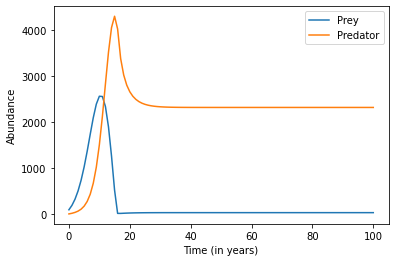

In [7]:
plt.plot(H_array, label='Prey')
plt.plot(P_array, label='Predator')
plt.legend()
plt.ylabel("Abundance")
plt.xlabel("Time (in years)")

## Running through params of interest

In [15]:
numyears = 100 # number of years to run simulation 

#Herbivore parameters:
r_H = 0.4 # growth rate of herbivores
K_H = 5000 # carrying capacity of herbivores
theta_H = 50 # immigration of herbivores
c = 0.4 #additional mortality of H 
d = 500 # value of H when predation half its max value 
q_H = 1. # proportionality constant for herbivore harvest 
E_H = 0.1 # Effort for herbivore harvest (0.05 = limit cycle, 0.2 = stable state)
#Predator parameters:
r_P = 0.2 # growth rate of predator 
K_P = 2000 # carrying capactiy of predators
b = 0.4 # additional growth of P due to H
theta_P = 10 # immigration of predators 
q_P = 1. # proportionality constant for predator harvest 
E_P = 0.1 # Effort for predator harvest

parameters_dict = {'numyears': numyears, 
                  'r_H': r_H, 
                  'K_H': K_H, 
                  'theta_H': theta_H,
                  'c': c, 
                  'd': d, 
                  'E_H': E_H,
                  'q_H': q_H, 
                  'r_P': r_P,
                  'K_P': K_P,
                  'theta_P': theta_P, 
                  'b': b,
                  'q_P': q_P, 
                  'E_P': E_P,
                  }

## Function to run through params at +/- 10%

In [16]:
# Function to vary parameters and document all parameter values
def run_model_with_varying_params(parameters_dict, params_to_vary, variation_range, H0, P0):
    # Initialize an empty list to store all results
    all_results = []
    
    # Loop through each parameter to vary
    for param in params_to_vary:
        # Store the original value of the parameter
        original_value = parameters_dict[param]
        
        # Generate values to vary the parameter within the specified range
        varied_values = np.linspace(
            original_value * (1 - variation_range),  # Lower bound
            original_value * (1 + variation_range),  # Upper bound
            10  # Number of variations (adjustable)
        )
        
        # Loop through each varied value for the current parameter
        for value in varied_values:
            # Update the parameter in the dictionary
            parameters_dict[param] = value
            
            # Run the model with the updated parameters
            H_array, P_array, H_harvest_array, P_harvest_array = run_model(H0, P0, parameters_dict)
            
            # Create a dictionary to store the results for this run
            result = {
                'H_final': H_array[-1],
                'P_final': P_array[-1]
            }
            
            # Add all parameter values to the result
            result.update(parameters_dict)
            
            # Append the result to the list
            all_results.append(result)
        
        # Reset the parameter to its original value
        parameters_dict[param] = original_value
    
    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(all_results)
    return results_df

## Testing Function to Make Sure it works

In [17]:
# Specify parameters to vary and their variation range
params_to_vary = ['r_H', 'K_H','theta_H', 'c', 'd', 'E_H','q_H','r_P','K_P', 'E_P','q_P', 'theta_P', 'b']  # Parameters to vary
variation_range = 0.1  # ±10% variation
H0 = 100
P0 = 10


# Run the function to vary parameters and collect results
results_df = run_model_with_varying_params(parameters_dict, params_to_vary, variation_range, H0, P0)

# Display all columns in the DataFrame
pd.set_option('display.max_columns', None)
print(results_df)

# Optionally save to a CSV
results_df.to_csv('data/pred_prey_data.csv', index=False)

       H_final      P_final  numyears       r_H     K_H  theta_H    c      d  \
0    61.293993  1503.324163       100  0.360000  5000.0     50.0  0.4  500.0   
1    61.853965  1506.725268       100  0.368889  5000.0     50.0  0.4  500.0   
2    62.422924  1510.174687       100  0.377778  5000.0     50.0  0.4  500.0   
3    63.001067  1513.673318       100  0.386667  5000.0     50.0  0.4  500.0   
4    63.588595  1517.222081       100  0.395556  5000.0     50.0  0.4  500.0   
..         ...          ...       ...       ...     ...      ...  ...    ...   
125  63.654374  1522.429934       100  0.400000  5000.0     50.0  0.4  500.0   
126  63.199369  1529.214686       100  0.400000  5000.0     50.0  0.4  500.0   
127  62.754846  1535.942031       100  0.400000  5000.0     50.0  0.4  500.0   
128  62.320396  1542.613436       100  0.400000  5000.0     50.0  0.4  500.0   
129  61.895629  1549.230306       100  0.400000  5000.0     50.0  0.4  500.0   

     E_H  q_H  r_P     K_P  theta_P    

## Run RF Analysis

In [18]:
data = pd.read_csv("data/pred_prey_data.csv")

X1 = data.iloc[:, 2:17]  # Columns 4-28 are explanatory
Y1 = data.iloc[:, 0:2]   # Columns 0-4 are response variables

regressor = RandomForestRegressor(n_estimators=100, random_state=42)

regressor.fit(X1, Y1)

# Predict using the model
predictions = regressor.predict(X1)

# Calculate Mean Squared Error
mse = mean_squared_error(Y1, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate R-squared
r2 = r2_score(Y1, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 4.25092703526785
R-squared: 0.9893429684224402


Feature Importances:
[0.00000000e+00 1.07013668e-02 2.06948757e-04 3.90698892e-02
 7.60556555e-02 8.77789514e-03 7.71852306e-04 7.38579786e-04
 4.22505958e-02 3.99603043e-01 8.34454157e-04 3.73914191e-02
 1.90385857e-01 1.93212443e-01]


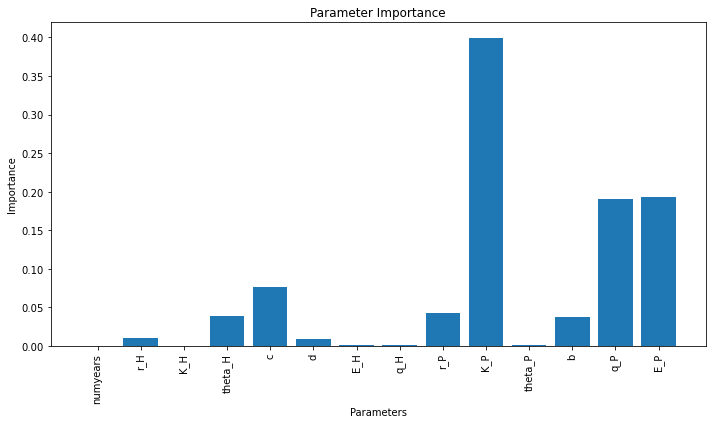

In [19]:
importances1 = regressor.feature_importances_

# Print importances
print("Feature Importances:")
print(importances1)

# Set up labels for the features (adjust based on your column names)
plotLabs1 = X1.columns  # Using column names directly for labeling

# Bar plot of importances
plt.figure(figsize=(10, 6))
plt.bar(plotLabs1, importances1, align="center")
plt.xticks(rotation=90) 
plt.xlabel("Parameters")
plt.ylabel("Importance")
plt.title("Parameter Importance")
plt.tight_layout()
plt.show()

In [21]:
# Define the list of columns to keep
columns_to_keep = ['r_H', 'K_H','theta_H', 'c', 'd', 'E_H','q_H','r_P','K_P', 'E_P','q_P', 'theta_P', 'b']

# Filter the columns and importances based on columns_to_keep
filtered_columns = [col for col in X1.columns if col in columns_to_keep]
filtered_importances1 = [importance for col, importance in zip(X1.columns, importances1) if col in columns_to_keep]

# LaTeX labels for filtered columns
filtered_labels = [f"${col}$" for col in filtered_columns]

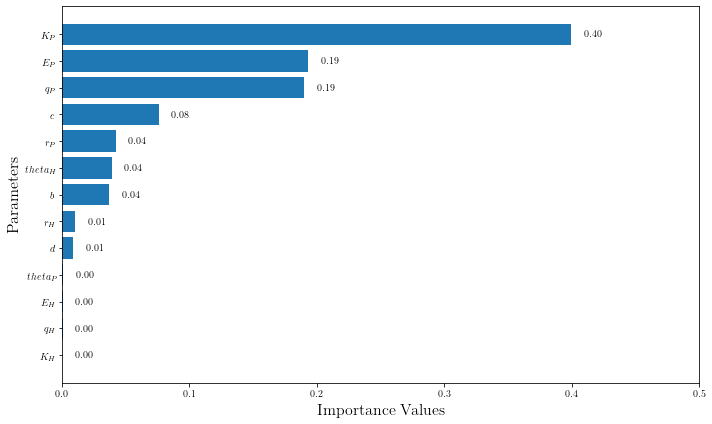

In [28]:
# Sort importances and labels for better visualization
sorted_indices = np.argsort(filtered_importances1)[::-1]
sorted_importances = np.array(filtered_importances1)[sorted_indices]
sorted_labels = np.array(filtered_labels)[sorted_indices]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_labels, sorted_importances)

# Add the importance values next to the bars
for i, val in enumerate(sorted_importances):
    plt.text(val + 0.01, i, f"{val:.2f}", va='center')

# Add labels and title
plt.xlabel("Importance Values", fontsize=16)
plt.ylabel("Parameters", fontsize=16)
#plt.title("Feature Importances", fontsize=16)
plt.xlim(0, 0.5)

# Invert the y-axis to have the most important features at the top
plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()